# Function Calling with images
- By Marcelo Rovai @17Oct25

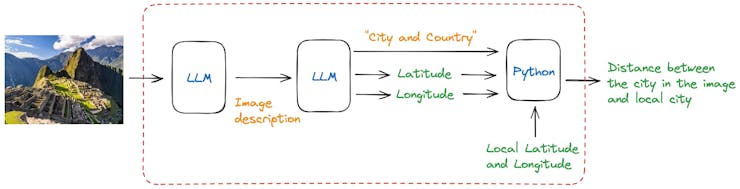

## Importing libraries

In [11]:
import time
from haversine import haversine
from ollama import chat
from pydantic import BaseModel, Field

import matplotlib.pyplot as plt
from PIL import Image

In [1]:
#img = sys.argv[1]
MODEL = 'gemma3:4b'
mylat = -33.33
mylon = -70.51

In [3]:
!ls *.jpg

 capt_image.jpg     image_test_1.jpg	 image_test_3.jpg
 class16_test.jpg  'image _test_2.jpg'	 image_test.jpg


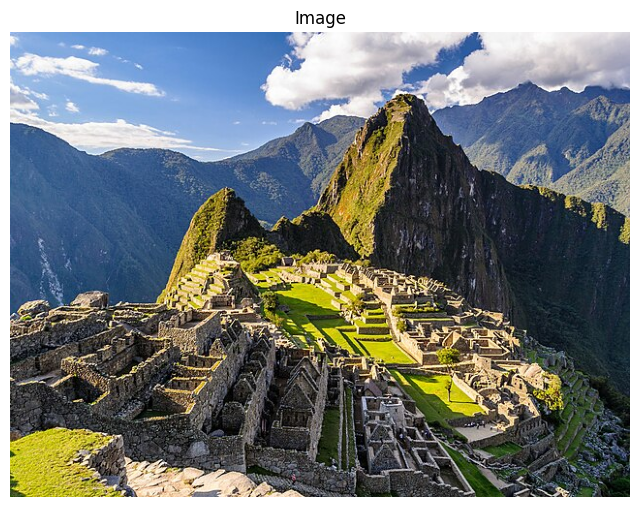

In [4]:
# Load the image
img_path = "image_test_3.jpg"
img = Image.open(img_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Image")
plt.show()

In [6]:
def image_description(img_path):
    with open(img_path, 'rb') as file:
        response = ollama.chat(
            model=MODEL,
            messages=[
              {
                'role': 'user',
                'content': '''return the decimal latitude and decimal longitude 
                              of the city in the image, its name, and what 
                              country it is located''',
                'images': [file.read()],
              },
            ],
            options = {
              'temperature': 0,
              }
      )
    #print(response['message']['content'])
    return response['message']['content']

In [7]:
image_description = image_description(img_path)

In [8]:
image_description

"Here's the information about the location in the image:\n\n*   **Name:** Machu Picchu\n*   **Latitude:** -13.1631\n*   **Longitude:** -72.5450\n*   **Country:** Peru"

In [9]:
class CityCoord(BaseModel):
    city: str = Field(..., description="Name of the city in the image")
    country: str = Field(..., description="Name of the country where the city in the image is located")
    lat: float = Field(..., description="Decimal Latitude of the city in the image")
    lon: float = Field(..., description="Decimal Longitude of the city in the image")

In [12]:
response = chat(
    model=MODEL,
    messages=[{
        "role": "user",
        "content": image_description # image_description from previous model
    }],
    format=CityCoord.model_json_schema(),  # Structured JSON format
    options={"temperature": 0}
)

In [13]:
response['message']['content']

'{\n  "city": "Machu Picchu",\n  "country": "Peru",\n  "lat": -13.1631,\n  "lon": -72.5450\n}\n'

In [14]:
resp = CityCoord.model_validate_json(response.message.content)
resp

CityCoord(city='Machu Picchu', country='Peru', lat=-13.1631, lon=-72.545)

In [15]:
resp.city, resp.country, resp.lat, resp.lon

('Machu Picchu', 'Peru', -13.1631, -72.545)

In [17]:
distance = haversine((mylat, mylon), (resp.lat, resp.lon), unit='km')

print(f"\nThe image shows {resp.city}, with lat:{round(resp.lat, 2)} and long: {round(resp.lon, 2)}, located in {resp.country} and about {int(round(distance, -1)):,} kilometers away from Santiago, Chile.\n")


The image shows Machu Picchu, with lat:-13.16 and long: -72.55, located in Peru and about 2,250 kilometers away from Santiago, Chile.



## Creating a function

In [32]:
def calc_dist_image (img_path, model=MODEL):
    start_time = time.perf_counter()  # Start timing

    img_descript = image_description(img_path)
    print("\n",img_descript)
    
    response = chat(
    model=MODEL,
    messages=[{
        "role": "user",
        "content": img_descript # image_description from previous model
    }],
    format=CityCoord.model_json_schema(),  # Structured JSON format
    options={"temperature": 0}
    )

    resp = CityCoord.model_validate_json(response.message.content)
    print("\n",resp)
    distance = haversine((mylat, mylon), (resp.lat, resp.lon), unit='km')
    
    end_time = time.perf_counter()  # End timing
    elapsed_time = end_time - start_time  # Calculate elapsed time
    
    print(f"\nThe image shows {resp.city}, with lat:{round(resp.lat, 2)} and \
long: {round(resp.lon, 2)}, located in {resp.country} and \
about {int(round(distance, -1)):,} kilometers away from Santiago, Chile.\n")

    print(f" [INFO] ==> The code (running {MODEL}), took {elapsed_time:.1f} \
seconds to execute.\n")

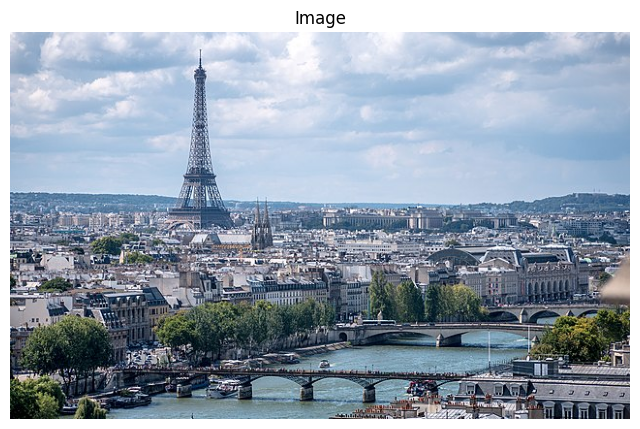

In [20]:
# Load the image
img_path = "image_test_1.jpg"
img = Image.open(img_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Image")
plt.show()

In [25]:
calc_dist_image (img_path, model=MODEL)


 Here's the information based on the image:

*   **City:** Paris
*   **Latitude:** 48.8566° N
*   **Longitude:** 2.3522° E
*   **Country:** France

 city='Paris' country='France' lat=48.8566 lon=2.3522

The image shows Paris, with lat:48.86 and             long: 2.35, located in France and             about 11,630 kilometers away from Santiago, Chile.

 [INFO] ==> The code (running gemma3:4b), took 223.8       seconds to execute.



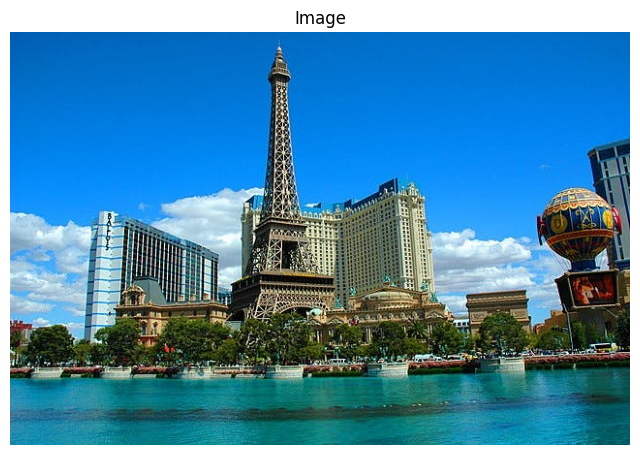

In [28]:
# Load the image
img_path = "image_test_2.jpg"
img = Image.open(img_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Image")
plt.show()

In [29]:
calc_dist_image (img_path, model=MODEL)


The image shows Las Vegas, with lat:36.09 and long: 115.15, located in United States of America and about 19,410 kilometers away from Santiago, Chile.

 [INFO] ==> The code (running gemma3:4b), took 228.0 seconds to execute.



## Testing with other models 

In [33]:
MODEL = 'moondream'
img_path = "image_test_1.jpg"
calc_dist_image (img_path, model=MODEL)


 
 [0.42, 0.3, 0.6, 0.39]

 city='new york' country='us' lat=0.41 lon=0.31

The image shows new york, with lat:0.41 and long: 0.31, located in us and about 8,260 kilometers away from Santiago, Chile.

 [INFO] ==> The code (running moondream), took 44.4 seconds to execute.



In [36]:
def image_description_2(img_path):
    with open(img_path, 'rb') as file:
        response = ollama.chat(
            model=MODEL,
            messages=[
              {
                'role': 'user',
                'content': '''Describe the image and try to identify where the image is, its name, and what 
                              country it is located. Also its latitude and longitude''',
                'images': [file.read()],
              },
            ],
            options = {
              'temperature': 0,
              }
      )
    print(response['message']['content'])
    #return response['message']['content']

In [37]:
image_description_2(img_path)


 The image shows a panoramic view of Paris, France from an elevated position. In the background, there are several buildings that make up the cityscape, including the iconic Eiffel Tower standing tall among them. The sky above is filled with clouds, adding to the overall atmosphere of the scene. The image also contains some boats on a river near the city, which further enhances the picturesque view of Paris.
 
The photo appears to be taken from an elevated position, possibly from a bridge or a high vantage point such as a rooftop or a hilltop. This perspective provides a comprehensive and stunning view of the city's architecture and natural surroundings.


In [45]:
def calc_dist_image_2 (img_path, model=MODEL):
    start_time = time.perf_counter()  # Start timing

    img_descript = image_description_2(img_path)
    print("\n",img_descript)
    
    response = chat(
    model='gemma3:4b',
    messages=[{
        "role": "user",
        "content": f"From the {img_descript}, return the name of the city, country,  Latitude and the Longitude"  # image_description from previous model
    }],
    format=CityCoord.model_json_schema(),  # Structured JSON format
    options={"temperature": 0}
    )

    resp = CityCoord.model_validate_json(response.message.content)
    print("\n",resp)
    distance = haversine((mylat, mylon), (resp.lat, resp.lon), unit='km')
    
    end_time = time.perf_counter()  # End timing
    elapsed_time = end_time - start_time  # Calculate elapsed time
    
    print(f"\nThe image shows {resp.city}, with lat:{round(resp.lat, 2)} and \
long: {round(resp.lon, 2)}, located in {resp.country} and \
about {int(round(distance, -1)):,} kilometers away from Santiago, Chile.\n")

    print(f" [INFO] ==> The code (running {MODEL}), took {elapsed_time:.1f} \
seconds to execute.\n")

In [46]:
calc_dist_image_2 (img_path, model=MODEL)


 The image shows a panoramic view of Paris, France from an elevated position. In the background, there are several buildings that make up the cityscape, including the iconic Eiffel Tower standing tall among them. The sky above is filled with clouds, adding to the overall atmosphere of the scene. The image also contains some boats on a river near the city, which further enhances the picturesque view of Paris.
 
The photo appears to be taken from an elevated position, possibly from a bridge or a high vantage point such as a rooftop or a hilltop. This perspective provides a comprehensive and stunning view of the city's architecture and natural surroundings.

 None

 city='London' country='United Kingdom' lat=51.5074 lon=0.1278

The image shows London, with lat:51.51 and long: 0.13, located in United Kingdom and about 11,670 kilometers away from Santiago, Chile.

 [INFO] ==> The code (running moondream), took 75.6 seconds to execute.

